In [1]:
import os
import sys
import time
import pickle
import numpy as np
from matplotlib import pyplot as plt, ticker
from skimage import measure, segmentation as seg, morphology as morph
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim
from pysar.objects import timeseries, ifgramStack, sensor, giantTimeseries
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet
import pysar.ifgram_inversion as ifginv
from pysar.unwrap_error_phase_closure import correct_unwrap_error

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/sim_phaseClosure')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# reference file
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
sensor_name = sensor.project_name2sensor_name(proj_dir)[0]
ts_file = os.path.join(proj_dir, 'timeseries.h5')
ts_obj = timeseries(ts_file)
ts_obj.open(print_msg=False)
ts_obj.save2bl_list_file(out_file='bl_list.txt')

tbase = np.array(ts_obj.tbase)
tbase_diff = np.diff(np.array(tbase, dtype=np.float32) / 365.25).reshape(-1, 1)
ts_sim = sim.sim_variable_timeseries(tbase, display=False)

date_list = ts_obj.dateList
dates, datevector = ptime.date_list2vector(date_list)

inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
phase2range = -1*float(ts_obj.metadata['WAVELENGTH'])/(4.*np.pi)

# Network Setup
num_conn = 5
date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
num_ifgram = len(date12_list)
A, B = ifgramStack.get_design_matrix4timeseries(date12_list=date12_list)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list)
print('number of ifgrams: {}'.format(num_ifgram))

## Decorrelation Noise Setup
coh_resid, decor_time = 0.0, 200  # 0.0, 50; 0.1, 50; 0.0, 200; 0.2, 200; 0.4, 200
num_sample = 100
L_max = 50
L = 3 * 9

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/sim_phaseClosure
write baseline list info to file: bl_list.txt
number of ifgrams: 475


In [6]:
## simulate interferograms without unwrapping errors
ifgram_est, coh_est = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                           L=L, num_sample=num_sample,
                                           baseline_file='bl_list.txt',
                                           sensor_name=sensor_name,
                                           inc_angle=inc_angle)[0:2]
ifgram = ifgram_est[:,0]
weight = ifginv.coherence2weight(coh_est, weight_func='var', L=L, print_msg=False)
weight_sqrt = np.sqrt(weight)
print('Done.')

Done.


In [30]:
## Simulate network of interferograms
# 1. interferograms with decorrelation noise
ifgram_err, idx_ifg_err = sim.add_unw_err2ifgram(ifgram)
ifgram_cor = correct_unwrap_error(ifgram_err, C)[0].flatten()
ts_err, tcoh_err = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram_err, weight_sqrt=weight_sqrt)[0:2]
ts_cor, tcoh_cor = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram_cor, weight_sqrt=weight_sqrt)[0:2]
ts_err *= phase2range
ts_cor *= phase2range

ifgram with unwrap error: 0.1
unwrap error jump in 2*pi*(-2, 2): 
number of ifgrams with unwrap error: 47


In [33]:
## ploting functions
def plot_network(ax, date12_list, idx_ifg_err, ts_obj):
    # plot acquisitions
    ax.plot(ts_obj.times, ts_obj.pbase, 'ko', alpha=0.7, ms=6, mfc=pp.mplColors[1])
    # plot all interferometric pairs
    for date12 in date12_list:
        date1, date2 = date12.split('_')
        idx1 = ts_obj.dateList.index(date1)
        idx2 = ts_obj.dateList.index(date2)
        x = [ts_obj.times[idx1], ts_obj.times[idx2]]
        y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
        ax.plot(x, y, '-', lw=2, alpha=0.7, c=pp.mplColors[0])
    # plot interferometric pairs with error
    for date12 in np.array(date12_list)[idx_ifg_err]:
        date1, date2 = date12.split('_')
        idx1 = ts_obj.dateList.index(date1)
        idx2 = ts_obj.dateList.index(date2)
        x = [ts_obj.times[idx1], ts_obj.times[idx2]]
        y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
        ax.plot(x, y, '-', lw=2, alpha=1.0, c=pp.mplColors[1])
    # axis format
    pp.auto_adjust_xaxis_date(ax, ts_obj.times, fontsize=font_size)
    ax.set_xlabel('Time [yr]', fontsize=font_size)
    ax.set_ylabel('Perp baseline [m]', fontsize=font_size)
    return ax

def plot_ifgram_bar(ax, ifgram, ifgram_err, ifgram_cor):
    wid = 3
    num_ifgram = len(ifgram)
    x = np.arange(num_ifgram)+1 - wid/2.
    ax.bar(x, ifgram_err - ifgram, width=wid, color=pp.mplColors[1])
    ax.bar(x, ifgram_cor - ifgram, width=wid, color=pp.mplColors[0])
    # error percentage
    perc0 = np.sum(np.abs(ifgram_err - ifgram) > 0.1) / num_ifgram
    perc1 = np.sum(np.abs(ifgram_cor - ifgram) > 0.1) / num_ifgram
    # axis format
    #ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
    ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
    ax.set_xlabel('Interferogram #', fontsize=font_size)
    ax.set_ylabel('Phase error [rad]', fontsize=font_size)
    print('Error percentage: {:.2f} -> {:.2f}'.format(perc0, perc1))
    return ax

def plot_timeseries(ax, ts_sim, ts_err, ts_cor, ts_obj):
    ax.plot(ts_obj.times, ts_sim * 100., 'k--', label='truth')
    ax.plot(ts_obj.times, ts_err * 100., 'o', mec=pp.mplColors[1], mfc='none', mew=1.5, label='before cor')
    ax.plot(ts_obj.times, ts_cor * 100., 's', color=pp.mplColors[0], alpha=0.5, label='after cor')
    pp.auto_adjust_xaxis_date(ax, ts_obj.times, fontsize=font_size)
    ax.set_xlabel('Time [yr]', fontsize=font_size)
    ax.set_ylabel('LOS displacement [cm]', fontsize=font_size)
    #ax.legend(fontsize=font_size)
    return ax

def plot_percentage(ax, conn_list=[3,5,10], max_cycle=2):
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ms = 2
    for i in range(len(conn_list)):
        ds = None
        out_file = 'stats_{:02d}cycle_D{:d}_{:02d}conn.pickle'.format(max_cycle, int(D), conn_list[i])
        with open(out_file, 'rb') as f:
            ds = pickle.load(f)
        #ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=(ms+i)**2, mfc='none', mec=pp.mplColors[i], label=conn_list[i])
        ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=2**2, color=pp.mplColors[i], label=conn_list[i])
    ax.plot(np.array([0,1]), np.array([0,1]), 'k--')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_xlabel('Error percentage before', fontsize=font_size)
    ax.set_ylabel('Error percentage after', fontsize=font_size)
    return ax

print('Done.')

Done.


Error percentage: 0.10 -> 0.02
saved to file sim_phase_closure.png


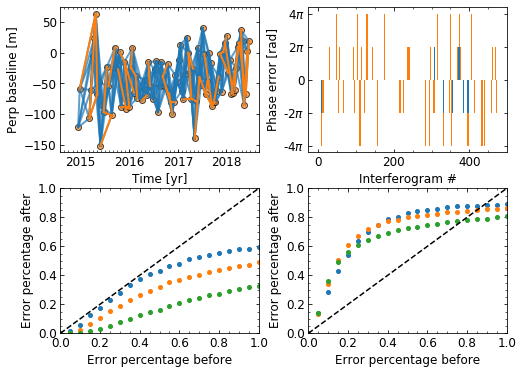

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 6])
plot_network(axs[0,0], date12_list, idx_ifg_err, ts_obj)
plot_ifgram_bar(axs[0,1], ifgram, ifgram_err, ifgram_cor)
#plot_timeseries(axs[1,0], ts_sim, ts_err, ts_cor, ts_obj)
plot_percentage(axs[1,0], conn_list=[3,5,10], max_cycle=2)
plot_percentage(axs[1,1], conn_list=[3,5,10], max_cycle=10)
fig.subplots_adjust(wspace=0.25, hspace=0.25)
#fig.tight_layout()

# axis format
for ax in axs.flatten():
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

# save
out_file = 'sim_phase_closure.png'
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

In [2]:
## Run performance
max_cycle = 2 # 2, 3, 5, 10
D = True
for num_conn in [3,5,10]:
    out_file = 'stats_{:02d}cycle_D{:d}_{:02d}conn.pickle'.format(max_cycle, int(D), num_conn)
    if not os.path.isfile(out_file):
        # simulate ifgram without unw err
        date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
        num_ifgram = len(date12_list)
        A, B = ifgramStack.get_design_matrix4timeseries(date12_list=date12_list)
        C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list)
        print('number of connections:', num_conn)
        print('number of ifgrams: {}'.format(num_ifgram))

        ifgram = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                      L=L, num_sample=1,
                                      baseline_file='bl_list.txt',
                                      sensor_name=sensor_name,
                                      inc_angle=inc_angle)[0].flatten()

        # calculate percentage change for various percentage of unw err
        print('calculating the improvement of unw err correction for various percentage of errors ...')
        num_perc = 21
        num_rep = 100
        perctage0s = np.linspace(0, 1, num=num_perc)
        perctage1s = np.zeros(num_perc, np.float32)
        prog_bar = ptime.progressBar(maxValue=num_perc)
        for i in range(num_perc):
            perc1 = 0
            for j in range(num_rep):
                ifgram_err = sim.add_unw_err2ifgram(ifgram, percentage=perctage0s[i], Nmax=max_cycle, print_msg=False)[0]
                ifgram_cor = correct_unwrap_error(ifgram_err, C, D)[0].flatten()
                perc1 += np.sum(np.abs(ifgram_cor - ifgram) > 0.1) / num_ifgram
            perc1 /= num_rep
            perctage1s[i] = perc1
            prog_bar.update(i+1)
        prog_bar.close()

        # save to pickle file
        ds = {}
        ds['num_conn'] = num_conn
        ds['num_repeat'] = num_rep
        ds['percentage0'] = perctage0s
        ds['percentage1'] = perctage1s
        with open(out_file, 'wb') as f:
            pickle.dump(ds, f)
        print('saved to pickle file {}.'.format(out_file))
        ds = dict(ds)
    else:
        print('{} exists, skip to the next.'.format(out_file))
print('Done.')

stats_02cycle_D1_03conn.pickle exists, skip to the next.
stats_02cycle_D1_05conn.pickle exists, skip to the next.
stats_02cycle_D1_10conn.pickle exists, skip to the next.
Done.


saved to file plot_stats_03cycle_D0.png


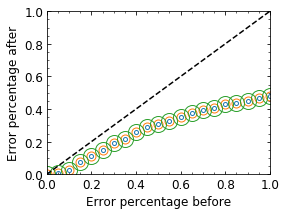

In [9]:
D = False

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 3])
plot_percentage(ax, conn_list=[3,5,10])
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

# save
out_file = 'plot_stats_{:02d}cycle_D{:d}.png'.format(max_cycle, int(D))
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()